In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "legend.fontsize": 18,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


In [3]:
out_path = "/users/amtseng/tfmodisco/figures/fold_model_motif_reproducibility_summary"
os.makedirs(out_path, exist_ok=True)

tf_names = [
    "E2F6", "FOXA2", "SPI1", "CEBPB", "MAX", "GABPA", "MAFK", "JUND", "NR3C1-reddytime", "REST"
]
tf_names_clean = tf_names[:]
tf_names_clean[8] = "NR3C1"

tf_num_tasks = {
    "E2F6": 2,
    "FOXA2": 4,
    "SPI1": 4,
    "CEBPB": 7,
    "MAX": 7,
    "GABPA": 9,
    "MAFK": 9,
    "JUND": 14,
    "NR3C1-reddytime": 16,
    "REST": 20
}

repro_hdf5s_base = "/users/amtseng/tfmodisco/figures/fold_model_motif_reproducibility"

repro_hdf5_paths = []  # (TF name, task index, path)
for subdir in os.listdir(repro_hdf5s_base):
    if not os.path.isdir(os.path.join(repro_hdf5s_base, subdir)):
        continue
    h5_name = [item for item in os.listdir(os.path.join(repro_hdf5s_base, subdir)) if item.endswith(".h5")][0]
    tf_name = subdir.split("_")[0]
    task_index = int(subdir.split("_")[1][4:])
    repro_hdf5_paths.append(
        (tf_name, task_index, os.path.join(repro_hdf5s_base, subdir, h5_name))
    )

### Helper functions

In [4]:
sanitize_fold = lambda fold: "F" + fold.split("_")[1]

def import_num_tfmodisco_motifs(motif_file, task_index=None):
    """
    From a file containing all motifs for that TF, imports the
    number of motifs discovered in each condition. Returns a
    dictionary mapping the condition to the number of motifs.
    If `task_index` is given, only considers the single-task motifs
    and fine-tuned multi-task motifs for that task. If `task_index`
    is None, only considers the multi-task motifs.
    """
    motif_counts = {}
    with h5py.File(motif_file, "r") as f:
        # Multi-task, all 10 folds
        if task_index is None:
            mt = f["multitask"]
            for fold in mt.keys():
                mt_fold = mt[fold]
                for key in ("count", "profile"):
                    mt_fold_key = mt_fold[key]
                    motif_counts["MT:%s:%s" % (sanitize_fold(fold), key[0].upper())] = len([
                        k for k in mt_fold_key.keys() if k.startswith("0_")
                    ])
        
        # Single-task, all 10 folds
        if task_index is not None:
            st = f["singletask"]
            task = "task_%d" % task_index
            st_task = st[task]
            for fold in st_task.keys():
                st_task_fold = st_task[fold]
                for key in ("count", "profile"):
                    st_task_fold_key = st_task_fold[key]
                    motif_counts["ST:%s:%s" % (sanitize_fold(fold), key[0].upper())] = len([
                        k for k in st_task_fold_key.keys() if k.startswith("0_")
                    ])
        
        # Multi-task fine-tune, all tasks or just one
        mtft = f["multitask_finetune"]
        task = "task_agg" if task_index is None else "task_%d" % task_index
        mtft_task = mtft[task]
        for key in ("count", "profile"):
            mtft_task_key = mtft_task[key]
            motif_counts["MTFT:%s" % (key[0].upper())] = len([
                k for k in mtft_task_key.keys() if k.startswith("0_")
            ])
        
        # Single-task fine-tune
        if task_index is not None:
            stft = f["singletask_finetune"]
            task = "task_%d" % task_index
            stft_task = stft[task]
            for key in ("count", "profile"):
                stft_task_key = stft_task[key]
                motif_counts["STFT:%s" % (key[0].upper())] = len([
                    k for k in stft_task_key.keys() if k.startswith("0_")
                ])
        
    return motif_counts

In [5]:
def get_total_reproducibility(repro_hdf5_path):
    """
    Imports the mean and stderr reproducibility value from the given
    saved HDF5.
    """
    with h5py.File(repro_hdf5_path, "r") as f:
        return f["total_mean_sim"][()], f["total_stderr_sim"][()]

### Import and plot number of TF-MoDISco motifs per task

In [6]:
tf_num_motifs = {}
for tf_name, num_tasks in tf_num_tasks.items():
    tf_num_motifs[tf_name] = []
    for task_index in range(num_tasks):
        motif_file = "/users/amtseng/tfmodisco/results/motifs/tfmodisco/%s_tfmodisco_motifs.h5" % tf_name
        tf_num_motifs[tf_name].append(
            import_num_tfmodisco_motifs(motif_file, task_index=task_index)
        )

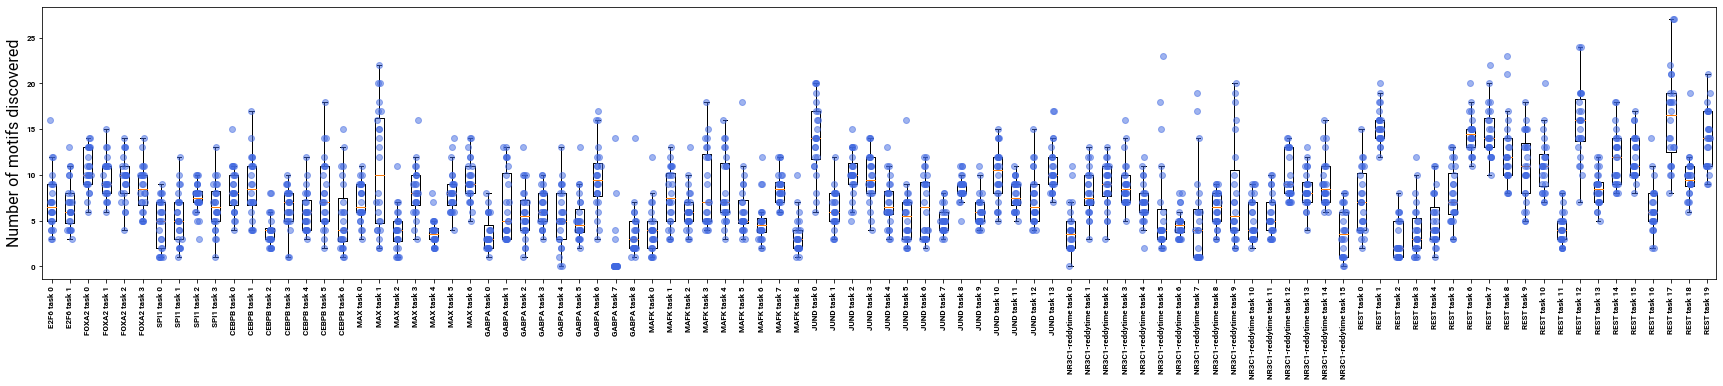

In [7]:
fig, ax = plt.subplots(figsize=(30, 5))

all_vals = [
    np.array(list(d.values())) for tf_name in tf_names for d in tf_num_motifs[tf_name]
]
labels = [
    "%s task %d" % (tf_name, task_index) for tf_name in tf_names for task_index in range(tf_num_tasks[tf_name]) 
]

ax.boxplot(all_vals, showfliers=False, zorder=0)
for i, vals in enumerate(all_vals):
    x = np.random.normal(i + 1, 0.06, len(vals))
    ax.scatter(x, vals, alpha=0.5, color="royalblue", zorder=1)
ax.set_ylabel("Number of motifs discovered")
ax.set_xticklabels(labels, rotation=90)

plt.savefig(
    os.path.join(out_path, "tf_num_motifs.svg"),
    format="svg"
)

### Import and plot reproducibility values

In [8]:
cond_keys = ["%s task %d" % (trip[0], trip[1]) for trip in repro_hdf5_paths]

In [9]:
total_repros = [get_total_reproducibility(trip[2])[0] for trip in repro_hdf5_paths]

In [10]:
def make_cdf(ax, data, steps=1000, density=False, inverse=False, **kwargs):
    """
    Plots a CDF to the given axes. `steps` is the number of steps in the
    CDF. If `inverse` is True, plots an inverse CDF (AKA survivorship plot).
    `density` is whether or not to normalize to fractions.
    """
    hist, bin_edges = np.histogram(data, bins=steps)
    if inverse:
        cumsum = len(data) - np.cumsum(hist)
    else:
        cumsum = np.cumsum(hist)
    if density:
        cumsum = cumsum / len(data)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    ax.step(bin_centers, cumsum, **kwargs)

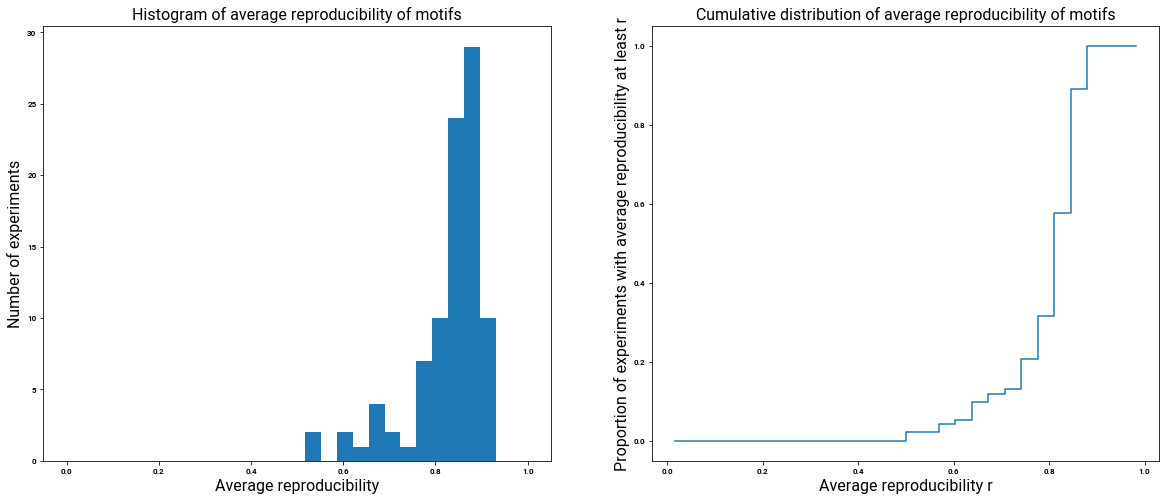

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

bins = np.linspace(0, 1, 30)

ax[0].hist(total_repros, bins=bins)

cdf_hist, cdf_bins = np.histogram(total_repros, bins=bins)
cdf_cumsum = np.cumsum(cdf_hist) / len(total_repros)
bin_centers = (cdf_bins[:-1] + cdf_bins[1:]) / 2.
ax[1].step(bin_centers, cdf_cumsum)

ax[0].set_title("Histogram of average reproducibility of motifs")
ax[1].set_title("Cumulative distribution of average reproducibility of motifs")

ax[0].set_xlabel("Average reproducibility")
ax[1].set_xlabel("Average reproducibility r")

ax[0].set_ylabel("Number of experiments")
ax[1].set_ylabel("Proportion of experiments with average reproducibility at least r")


plt.savefig(
    os.path.join(out_path, "fold_model_motif_reproducibility_summary.svg"),
    format="svg"
)
plt.show()